In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

# try to load the data and present some example images

there are 2000 grayscale images, 200 from each class

15 x 16 = 240 pixels

first 200 rows are 0, next 200 are 1, etc

In [2]:
raw_data = []
with open('./ProjectDigits_materials/mfeat-pix.txt', 'r') as f:
    for line in f:
        pixels = []
        for c in line:
            if c.isdigit():
                pixels.append(int(c))
        raw_data.append(pixels)
raw_data = np.array(raw_data)

In [3]:
raw_data.shape

(2000, 240)

In [4]:
def n_image_in_category(data) -> int:
    return int(data.shape[0] / 10)


def sample_images_for_each_digit(data, n_samples=5) -> list:
    n_images = n_image_in_category(data)
    sample_images = []
    for digit in range(10):
        sample_indices = np.random.choice(n_images, n_samples, replace=False)
        sample = data[digit * n_images + sample_indices]
        for img in sample:
            sample_images.append(img)
    return sample_images


def plot_sample_for_each_digit(data, n_samples=5, figsize=(10, 20), horizontal=False):
    fig = plt.figure(figsize=figsize)
    sample_images = sample_images_for_each_digit(data, n_samples)

    for i in range(len(sample_images)):
        row, col = (10, n_samples) if not horizontal else (n_samples, 10)
        fig.add_subplot(row, col, i + 1)

        img = sample_images[i].reshape(16, 15)
        plt.imshow(img, cmap='gray', vmin=0, vmax=6)
        plt.axis('off')

In [5]:
np.random.seed(1)

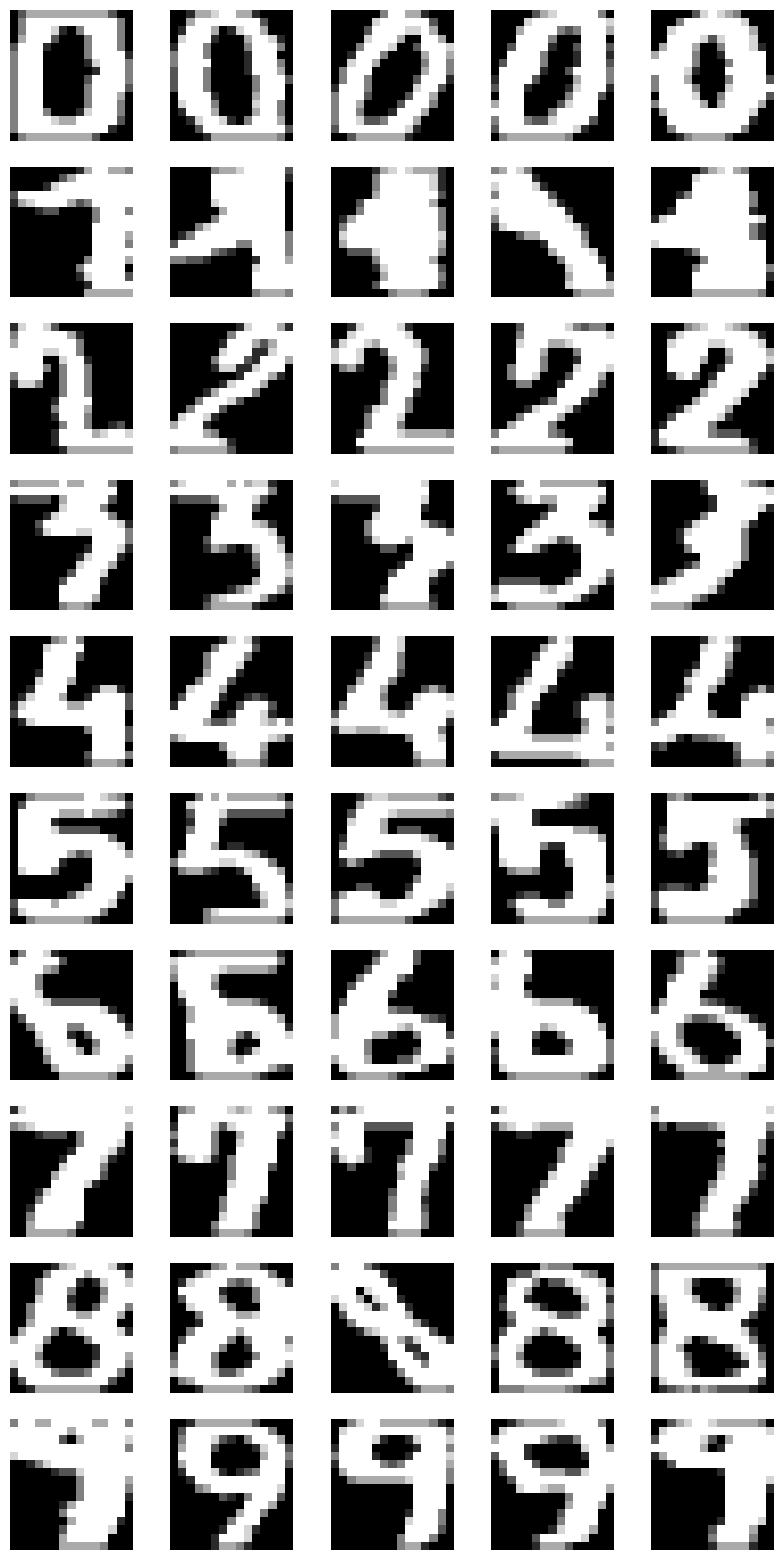

In [6]:
plot_sample_for_each_digit(raw_data, 5, (10, 20))

In [7]:
# split the data into train and test sets
n_images = n_image_in_category(raw_data)
split = int(n_images / 2)

#random split
# split_indices = [row * n_images + np.random.choice(n_images, split, replace=False) for row in range(10)]

# real split
split_indices = [np.arange(i * 200, i * 200 + 100) for i in range(10)]

split_indices = np.array(split_indices).flatten()
train_data = raw_data[split_indices]
test_data = np.delete(raw_data, split_indices, axis=0)


In [8]:
#sanity checks
assert (n_images == 200 and split == 100)
assert (train_data.shape == test_data.shape == (1000, 240))
# plot_sample_for_each_digit(train_data, 5, (5, 10))
# plot_sample_for_each_digit(test_data, 5, (5, 10))

# Linear regression (from the lecture notes)
given a collection of N training data points (xi, yi) where xi in R^n and yi in R
  - we have N = 1000
  - n = 240
  - range of xi is 0-6
  - range of yi is 0-9

Wanted: linear map from R^240 to R, represented by a _regression weight vector_ *w* (a row vector of size n = 240), which solves the minimization problem:
  - *w* = argmin_w sum_i (w \* xi - yi)^2
  - adding a bias to the argmin_w term, we get an affine linear function:
    - *w, b* = argmin_w,b sum_i (w \* xi + b - yi)^2
  - the bias can be added by adding a constant 1 to the end of each xi

Notes continue to explain that the n values of each component of the input vectors create n-dimensional vectors (p1,..., pn) a *?(not sure)* dimensional subspace *_F_* in R^N. The N target values of y also create a N-dimensional vector, our problem is finding a linear combination yopt = w1\*p1+...+wn\*pn that minimizes the distance to the target vector y given by the projection of y on *_F_*.

To solve we might need to understand a bit of linear algebra, but the application might do as well:
Define X = (p1...pn)', a matrix of size n x N which rows are p1,...,pn and columns are xi.
Also define y as a column vector of size N, with the target values yi.
Then we can find w_opt by w' = (XX')^-1 Xy

an optimization called _ridge regression_ is possible here by adding a small multiple of *I* (Identity) before doing the inverse:
 - w' = (XX' + small_value*I)^-1 Xy

#### Now lets try it

Perform linear ridge regression on the raw images
one-hot encode the labels

In [9]:
def perform_linear_ridge_regression(X, y, tiny=0.00001):
    w_prime = np.linalg.inv((X.T @ X) + tiny * np.identity(X.shape[1])) @ X.T @ y
    w_opt = w_prime.T
    return w_opt

In [10]:
X = train_data

# one-hot encode the labels
n_images = n_image_in_category(train_data)
y = np.zeros((X.shape[0], 10), dtype=np.int64)
for i in range(10):
    for j in range(n_images):
        y[i * n_images + j, i] = 1

w_opt = perform_linear_ridge_regression(X, y)

Test our classifier

In [11]:
def evaluate_w_opt(w_opt, train_data, test_data, y_train, y_test, verbose=True):
    """
    Evaluate by calculating the misclassification rate on training and test set 
    """
    misclassified_train = 0
    misclassified_test = 0

    for i in range(test_data.shape[0]):
        prediction = w_opt @ train_data[i]

        if np.argmax(prediction) != np.argmax(y_train[i]):
            misclassified_train += 1

        prediction = w_opt @ test_data[i]
        if np.argmax(prediction) != np.argmax(y_test[i]):
            misclassified_test += 1

    if verbose:
        print(
            f"train: misclassified: {misclassified_train}, misclassification rate: {misclassified_train / y.shape[0] * 100:.1f}%")
        print(
            f"test: misclassified: {misclassified_test}, misclassification rate: {misclassified_test / y.shape[0] * 100:.1f}%")
    return misclassified_train, misclassified_test

In [12]:
evaluate_w_opt(w_opt, train_data, test_data, y, y)

train: misclassified: 23, misclassification rate: 2.3%
test: misclassified: 99, misclassification rate: 9.9%


(23, 99)

Compare to random

In [13]:
random_results = []
for _ in range(X.shape[0]):
    misclassified_random = 0
    choices = np.random.random(test_data.shape[0]) * 9
    for i in range(test_data.shape[0]):
        if round(choices[i]) != np.argmax(y[i]):
            misclassified_random += 1
    random_results.append(misclassified_random / test_data.shape[0])
random_results = np.array(random_results)

Random Misclassification Rate -- mean: 90.04%, min: 86.70%, max: 92.90%


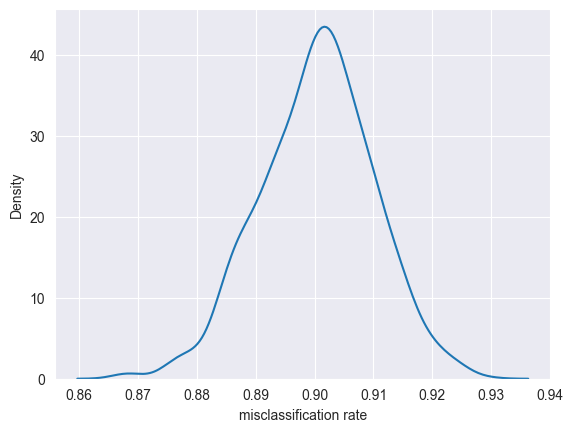

In [14]:
sns.kdeplot(random_results)
plt.xlabel("misclassification rate")
print(
    f"Random Misclassification Rate -- mean: {np.mean(random_results) * 100:.2f}%, min: {np.min(random_results) * 100:.2f}%, max: {np.max(random_results) * 100:.2f}%")

# Results ??

### using prototype vectors based on class means (from the lecture notes)

In [15]:
mean_train = []
n_images = n_image_in_category(train_data)
for i in range(10):
    start_index = i * n_images
    mean_train.append(np.mean(train_data[start_index:start_index + n_images], axis=0))
mean_train = np.array(mean_train)
mean_train.shape

(10, 240)

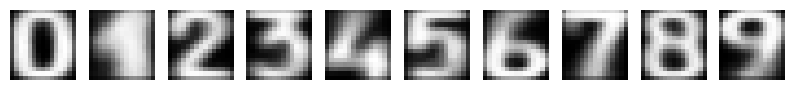

In [16]:
plot_sample_for_each_digit(mean_train, 1, (10, 1), horizontal=True)

In [17]:
feature_values_train = train_data @ mean_train.T
feature_values_test = test_data @ mean_train.T
feature_values_train.shape

(1000, 10)

now we have reduced x from 240 features to 10

try ridge regression again

In [18]:
w_opt = perform_linear_ridge_regression(feature_values_train, y)

In [19]:
evaluate_w_opt(w_opt, feature_values_train, feature_values_test, y, y)

train: misclassified: 88, misclassification rate: 8.8%
test: misclassified: 91, misclassification rate: 9.1%


(88, 91)


Next we try to use PCA to find the features / pixels introducing the most variance in our training set. This could lead to better results.

Use k-fold cross-validation for more valid results.

In [20]:
def train_val_split(training_data, y, n_folds, fold):
    n_images_per_class = n_image_in_category(training_data)
    n_validation_images = int(n_images / n_folds)
    indices_offset = n_validation_images * fold 
    val_indices = [list(range(i * n_images_per_class + indices_offset, i * n_images_per_class + indices_offset + n_validation_images)) for i in range(10)]
    val_indices = np.array(val_indices).flatten()
    return np.delete(training_data, val_indices, axis=0), training_data[val_indices], np.delete(y, val_indices, axis=0),y[val_indices]

In [32]:
results = []
n_folds = 5
for i in range(240):
    k_fold_results = np.zeros((n_folds, 2))
    for k in range(n_folds):
        train_set, val_set, train_y, val_y = train_val_split(train_data, y, n_folds, k)

        pca = PCA(n_components=i + 1, svd_solver='full')
        fitted = pca.fit(train_set)
        train_pca = fitted.transform(train_set)
        test_pca = fitted.transform(val_set)
    
        w_opt = perform_linear_ridge_regression(train_pca, train_y)
        result = evaluate_w_opt(w_opt, train_pca, test_pca, train_y, val_y, verbose=False)
        
        # calculate misclassification rates for train and val splits
        misclassification_rates = np.array(result) / val_y.shape[0]
        k_fold_results[k] = misclassification_rates
    
    results.append(np.mean(k_fold_results, axis=0))
results = np.array(results)

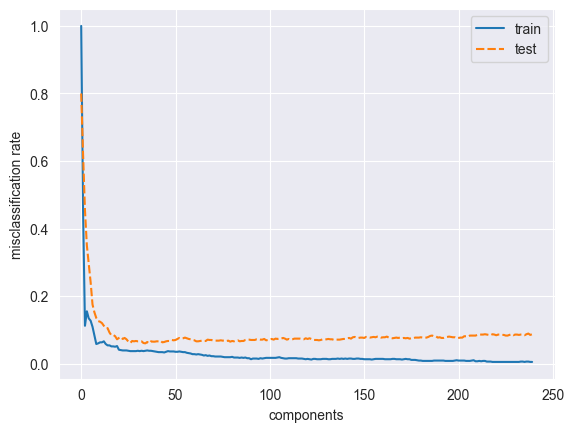

In [33]:
df = pd.DataFrame(results, columns=['train', 'test'])
sns.lineplot(data=df)
plt.xlabel("components")
plt.ylabel("misclassification rate")
plt.show()

In [35]:
print(f"best train result of PCA: {np.min(results[:, 0]) * 100:.1f}% for {np.argmin(results[:, 0])} components")
print(f"best test  result of PCA: {np.min(results[:, 1]) * 100:.1f}% for {np.argmin(results[:, 1])} components")
best_test_n_components = np.argmin(results[:, 1])

best train result of PCA: 0.5% for 218 components
best test  result of PCA: 6.0% for 34 components


In [36]:
pca = PCA(n_components=best_test_n_components, svd_solver='full')
fitted = pca.fit(train_data)
train_pca = fitted.transform(train_data)
test_pca = fitted.transform(test_data)

w_opt = perform_linear_ridge_regression(train_pca, y)
confidences = [[], []]
misclassified_images = []
misclassified_image_y = []
for i in range(y.shape[0]):
    img = test_pca[i]
    prediction = w_opt @ img
    highest = np.argmax(prediction)
    prediction = prediction[highest]
    real = np.argmax(y[i])
    if highest == real:
        confidences[0].append(prediction)
    else:
        confidences[1].append(prediction)
        misclassified_images.append(img)
        misclassified_image_y.append((real, highest))
misclassified_image_y = np.array(misclassified_image_y)
misclassified_images = pca.inverse_transform(misclassified_images)

In [37]:
evaluate_w_opt(w_opt, train_pca, test_pca, y, y)

train: misclassified: 53, misclassification rate: 5.3%
test: misclassified: 61, misclassification rate: 6.1%


(53, 61)

<Axes: ylabel='Density'>

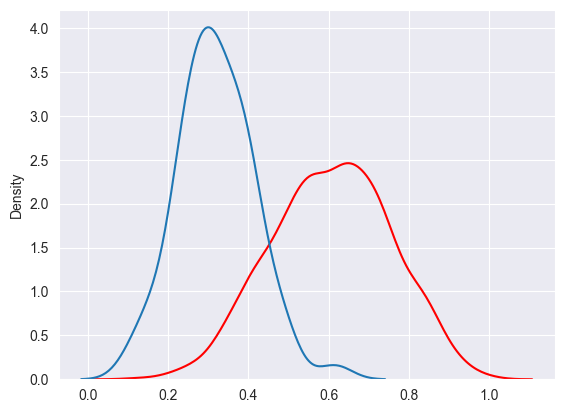

In [38]:
sns.kdeplot(confidences[0], color='r')
sns.kdeplot(confidences[1])


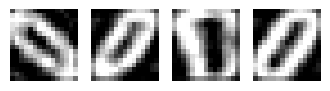

4        4        9        6


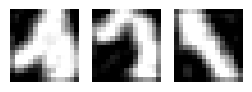

4        9        4


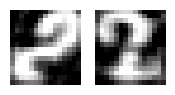

6        7


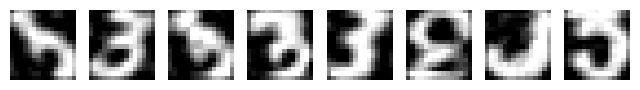

4        9        2        2        6        6        6        0


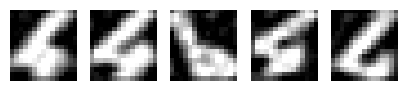

6        1        6        1        1


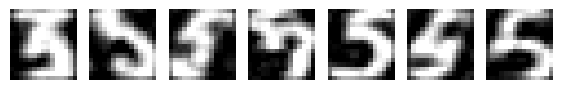

3        4        6        9        3        6        4


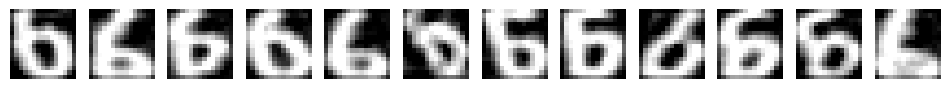

5        4        5        5        4        1        5        5        3        5        5        4


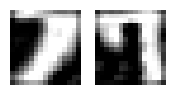

3        9


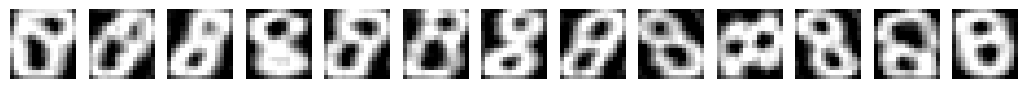

5        1        1        9        5        5        1        9        2        1        9        0        0


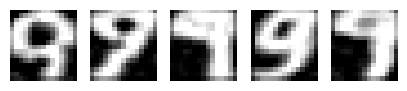

0        7        1        1        7


In [39]:
misclassified_per_class = [[] for _ in range(10)]
misclassified_per_class_y = [[] for _ in range(10)]
current_class = -1

for i in range(misclassified_image_y.shape[0]):
    real = misclassified_image_y[i, 0]
    if real != current_class:
        current_class = real
    misclassified_per_class[current_class].append(misclassified_images[i])
    misclassified_per_class_y[current_class].append(misclassified_image_y[i])

for k, images in enumerate(misclassified_per_class):
    img_in_class = len(images)
    if img_in_class > 0:
        figure = plt.figure(figsize=(img_in_class, 1))
        for i, img in enumerate(images):
            figure.add_subplot(1, img_in_class, i+1)
    
            img = img.reshape(16, 15)
            plt.imshow(img, cmap='gray', vmin=0, vmax=6)
            plt.axis('off')
        plt.show()
        predictions = [str(i[1]) for i in misclassified_per_class_y[k]]
        print('        '.join(predictions))
